In [ ]:
#!pip install numba

In [1]:
import numba
import numba.cuda as cuda

import numpy as np
import matplotlib.pyplot as plt

import time

sizes : 
(32, 32)
(31, 31)


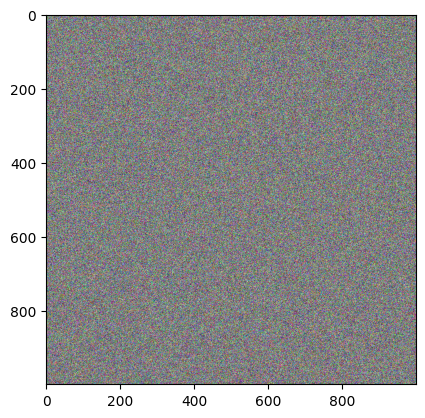

ERROR:numba.cuda.cudadrv.driver:Call to cuLaunchKernel results in CUDA_ERROR_INVALID_VALUE


CudaAPIError: [1] Call to cuLaunchKernel results in CUDA_ERROR_INVALID_VALUE

In [5]:


imageWidth = 1000
imageHeight = 1000
blockSize = (32,32)
gridX = imageWidth / blockSize[0]
gridY = imageHeight / blockSize[1]
gridSize = (int(gridX),int(gridY))
maxBlockSize = 80

print("sizes : ")
print(blockSize)
print(gridSize)

hostData = np.random.randint(0, 255, (imageHeight, imageWidth, 3), dtype=np.uint8)

plt.imshow(hostData)
plt.show()

print(cuda.threadIdx.x)

@cuda.jit

#kernelName[numBlock, blockSize](args)
def grayscale(src, out):
  srcSize = src.shape[1]
  tidx = cuda.threadIdx.x + cuda.blockIdx.x * cuda.blockDim.x
  tidy = cuda.threadIdx.y + cuda.blockIdx.y * cuda.blockDim.y
  x = tidx #% srcSize
  y = tidy #// srcSize

  if x < srcSize and y < srcSize:
    gray = np.uint8 ((src[x,y,0]+src[x,y, 1]+ src[x,y, 2]) / 3)
    out[x,y, 0] = out[x,y, 1] = out[x,y, 2] = gray

time_per_block_size = np.zeros(maxBlockSize)


for i in range(1,maxBlockSize):
  if i<=32:
    blockSize = (i*32,i*32)


  start_time = time.time()

  devData = cuda.to_device(hostData)
  #devData = cuda.device_array
  devOutput = cuda.device_array((imageHeight, imageWidth, 3), np.uint8)

  pixelCount = imageWidth * imageHeight
  #gridSize = int(pixelCount / blockSize)

  grayscale[gridSize, blockSize](devData, devOutput)

  hostOutput = devOutput.copy_to_host()

  end_time = time.time()
  run_time = end_time-start_time
  np.append(time_per_block_size, run_time)
  time_per_block_size[blockSize[0]] = run_time
  #print(run_time)

print("Time to run is: ")
print(time_per_block_size)
time_per_block_size[0] = 0

plt.imshow(hostOutput)
plt.show()
plt.plot(time_per_block_size)
plt.show()